In [1]:
import pandas as pd
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
RDLogger.DisableLog('rdApp.*')

def get_isomer(inchi):
    mol = Chem.MolFromInchi(inchi)
    isomers = tuple(EnumerateStereoisomers(mol))
    isomers = sorted(Chem.MolToInchi(i) for i in isomers)
    return isomers[0]

def replace_first_space(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            first_space_index = line.find(' ')
            modified_line = line[:first_space_index] + ';' + line[first_space_index + 1:]
            outfile.write(modified_line)

def eli_lilly_filter(flagreason: str):
    rules = [
        "no_interesting_atoms",
        "too_few_rings",
        "too_many_rings",
        "biotin",
        "too_many_aromatic_rings_in_ring_system",
        "ring_system_too_large",
        "ring_system_too_large_with_aromatic",
        "fmoc",
        "positive",
        "negative",
        "too_long_carbon_chain",
        "diphosphate",
        "quaternary_amine",
        "sulfonic_acid",
        "quaternary_amine",
        "crown_2_2_cyclic",
        "crown_3_3_cyclic",
        "crown_2_3_cyclic",
        "crown_2_2",
        "crown_3_3",
        "crown_2_3",
        "phenylenediamine",
        "LongCChain"
             ]
    for i in rules:
        if i in flagreason:
            return None
    return 0

In [2]:
replace_first_space("./original_outputs/bad0.smi", "./parsed_outputs/parsed_smi_0.smi")
replace_first_space("./original_outputs/bad1.smi", "./parsed_outputs/parsed_smi_1.smi")
replace_first_space("./original_outputs/bad2.smi", "./parsed_outputs/parsed_smi_2.smi")
replace_first_space("./original_outputs/bad3.smi", "./parsed_outputs/parsed_smi_3.smi")
replace_first_space("./original_outputs/good.smi", "./parsed_outputs/good.smi")

In [3]:
df0 = pd.read_csv("./parsed_outputs/parsed_smi_0.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df1 = pd.read_csv("./parsed_outputs/parsed_smi_1.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df2 = pd.read_csv("./parsed_outputs/parsed_smi_2.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df3 = pd.read_csv("./parsed_outputs/parsed_smi_3.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df4 = pd.read_csv("./parsed_outputs/good.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])

df_pos = pd.concat([df0, df1, df2, df3])
df_pos["pred"] = 1
df_neg = df4
df_neg["pred"] = 0
df = pd.concat([df_pos, df_neg])
df

,SMILES,FlagReason,pred
0,C=CCN=C=S,TP1 not_enough_atoms,1
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1
2,C(Cl)C1OC1,TP1 not_enough_atoms,1
3,C(Br)C1OC1,TP1 not_enough_atoms,1
4,C(F)C1OC1,TP1 not_enough_atoms,1
...,...,...,...
143,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0
144,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0
145,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0
146,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0


In [4]:
df["remove"] = df.FlagReason.apply(eli_lilly_filter)
df = df.dropna().drop("remove", axis=1)
df["InChI"] = df.SMILES.apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
df["InChI"] = df.InChI.apply(get_isomer)
df

,SMILES,FlagReason,pred,InChI
0,C=CCN=C=S,TP1 not_enough_atoms,1,"InChI=1S/C4H5NS/c1-2-3-5-4-6/h2H,1,3H2"
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1,InChI=1S/C31H29ClFN5O3/c32-22-8-2-6-18-5-1-7-2...
2,C(Cl)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5ClO/c4-1-3-2-5-3/h3H,1-2H2"
3,C(Br)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5BrO/c4-1-3-2-5-3/h3H,1-2H2"
4,C(F)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5FO/c4-1-3-2-5-3/h3H,1-2H2"
...,...,...,...,...
143,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0,InChI=1S/C8H12O2/c1-2-6-8(10-6)4-3-7-5(1)9-7/h...
144,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0,InChI=1S/C15H12N2O2/c16-15(18)17-11-7-3-1-5-9(...
145,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0,InChI=1S/C21H21NO/c1-22-12-10-14(11-13-22)19-1...
146,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0,InChI=1S/C8H6N2O/c11-8-5-9-6-3-1-2-4-7(6)10-8/...


In [5]:
test_data_df = pd.read_csv("../data/SMILES_test/test_data_all.csv")
test_data_df["InChI"] = test_data_df.SMILES.apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
test_data_df["InChI"] = test_data_df.InChI.apply(get_isomer)
test_data_df = test_data_df[["InChI", "warhead_category", "covalent", "SMILES"]]

In [6]:
df_final = df.merge(test_data_df, how="left", on=["InChI"])
# [["InChI", "covalent", "FlagReason", "pred"]]
# df_final.pred = df_final.pred.fillna(0)
df_final = df_final.dropna()
df_final

,SMILES_x,FlagReason,pred,InChI,warhead_category,covalent,SMILES_y
0,C=CCN=C=S,TP1 not_enough_atoms,1,"InChI=1S/C4H5NS/c1-2-3-5-4-6/h2H,1,3H2",thiocyanate,1.0,[H]C([H])=C([H])C([H])([H])N=C=S
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1,InChI=1S/C31H29ClFN5O3/c32-22-8-2-6-18-5-1-7-2...,lactone,1.0,[H]c1c([H])c(Cl)c2c(-c3nc([H])c4c(N5C([H])([H]...
2,C(Cl)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5ClO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(Cl)C1([H])OC1([H])[H]
3,C(Br)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5BrO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(Br)C1([H])OC1([H])[H]
4,C(F)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5FO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(F)C1([H])OC1([H])[H]
...,...,...,...,...,...,...,...
604,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0,InChI=1S/C8H12O2/c1-2-6-8(10-6)4-3-7-5(1)9-7/h...,noncovalentdecoy,0.0,[H]C1([H])C([H])([H])[C@]2([H])O[C@]2([H])C([H...
605,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0,InChI=1S/C15H12N2O2/c16-15(18)17-11-7-3-1-5-9(...,noncovalentdecoy,0.0,[H]N=C(O[H])N1c2c([H])c([H])c([H])c([H])c2[C@]...
606,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0,InChI=1S/C21H21NO/c1-22-12-10-14(11-13-22)19-1...,noncovalentdecoy,0.0,[H]c1c([H])c([H])c2c(c1[H])C(=C1C([H])([H])C([...
607,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0,InChI=1S/C8H6N2O/c11-8-5-9-6-3-1-2-4-7(6)10-8/...,noncovalentdecoy,0.0,[H]c1c([H])c([H])c2c(nc([H])c(=O)n2[H])c1[H]


### Why does eli lilly generate new structures?

In [7]:
test_inchies = set(test_data_df.InChI.values)
eli_inchies = set(df.InChI.values)
to_remove = test_inchies.intersection(eli_inchies)

test_inchies = sorted(list(test_inchies - to_remove))
eli_inchies = sorted(list(eli_inchies - to_remove))


In [8]:
eli_inchies[0], test_inchies[0]

('InChI=1S/C15H11N3O3S2/c19-12-8(13-18(12)10(6-22-13)14(20)21)4-7-5-17-9-2-1-3-11(9)23-15(17)16-7/h4-6,13H,1-3H2,(H,20,21)/b8-4+',
 'InChI=1S/C12H10ClN5O/c1-18-3-4-2-5(12(16)19)17-10-6(4)11(18)9(15)7(13)8(10)14/h2-3H,1H3,(H5,14,15,16,19)/p+1')

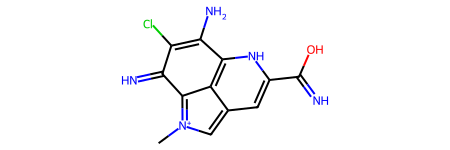

In [9]:
# Chem.MolFromInchi(eli_inchies[0])
Chem.MolFromInchi(test_inchies[0])

### Compare metrics

In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
(
    precision_score(df_final.covalent, df_final.pred),
    recall_score(df_final.covalent, df_final.pred),
    f1_score(df_final.covalent, df_final.pred),
)


/home/vh/miniconda3/envs/molgraph/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(0.8066666666666666, 0.8746987951807229, 0.8393063583815028)

In [11]:
1 - accuracy_score(
    df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
    df_final.query("warhead_category == 'noncovalentdecoy'").pred,
                   )

0.7446808510638299

In [12]:
import tensorflow as tf
import math
from helpers import encoder
model_file = "../saved_models/GCNII"
model = tf.keras.models.load_model(model_file)
gnn_pred = model.predict(encoder(df_final.InChI.values))

2023-12-22 16:20:35.476814: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 16:20:35.478116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 16:20:35.503762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 16:20:35.504502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-22 16:20:35.977952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/vh/miniconda3/envs/molgraph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-22 16:20:36.571226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 16:20:36.571554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflo

19/19 [==============================] - 4s 7ms/step


In [13]:
cutoff = 0.25
df_final["gnn_pred"] = gnn_pred
df_final["gnn_pred"] = df_final.gnn_pred.apply(lambda x: math.ceil(x) if x > cutoff else math.floor(x))

In [14]:
(
    precision_score(df_final.covalent, df_final.gnn_pred),
    recall_score(df_final.covalent, df_final.gnn_pred),
    f1_score(df_final.covalent, df_final.gnn_pred),
)

(0.8763157894736842, 0.8024096385542169, 0.8377358490566037)

In [15]:
1 - accuracy_score(
    df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
    df_final.query("warhead_category == 'noncovalentdecoy'").gnn_pred,
                   )

0.574468085106383